In [1]:

#Here come my imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV




import xgboost as xgb
from scipy.fft import fft


In [2]:

#Load data
month_df=pd.read_csv('monthly_energy_consumption.csv',index_col=[0],parse_dates=True)
dates=month_df.index
month=month_df.values.astype('float32')
test=month[:5]
month_df

,energy
Datetime,
2005-01-31,12735114.0
2005-02-28,11085745.0
2005-03-31,11847502.0
2005-04-30,10102660.5
2005-05-31,10181694.0
...,...
2018-03-31,11242396.5
2018-04-30,9820256.0
2018-05-31,10503052.0


In [3]:
## Loading the dataframe with previous RMSE where we stored results
results=pd.read_csv('scores.csv',index_col=[0])
results

,rmse_per_million
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
arima,0.737348
holt_linear,0.929768
SES,0.942778
moving_average,0.944048
simple_average,1.122177
naive,1.325609


Data Points 19


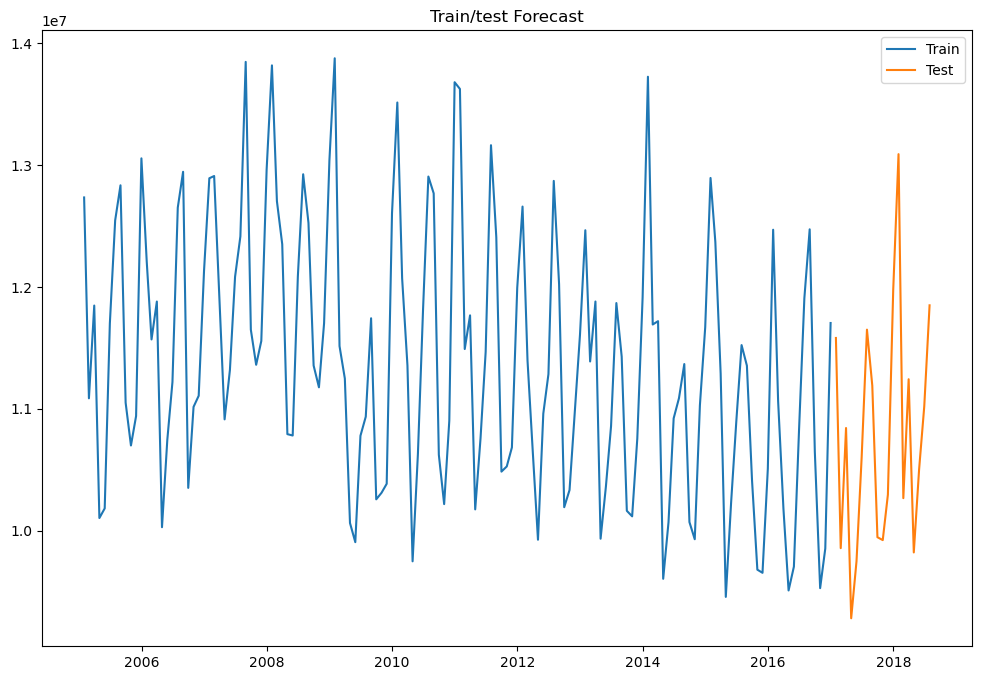

In [4]:
#This time around we have to define the number of the data points belonging to the test
n_test=len(month_df.loc['2017':'2018'])
print('Data Points', n_test)
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
#plt.plot(month_df.index[-n_test:],preds, label='RandomForest')
plt.legend(loc='best')
plt.title("Train/test Forecast");

<a id='start'></a>

* I am going to use to different ways to use RandomForest and XGBoost for forecasting.

    1. [**Building up**](#bu). This is a method where I create a train set and then I make a single prediction for the first future dta point. After incorporating that forecast to my collection, we repeat the process up until it is completed<br>
        * I use as a refernce this link from [Jason Brownlee (Thank you)](https://machinelearningmastery.com/random-forest-for-time-series-forecasting/)
    2. [**Train/test split**](#train_test). This is the most traditional way of partioning the data set in train/test and then using TimeSeriesSplit to account for the fact that it is a Time Series. iResults, as you will see, are way better. This is concerning to me. I have to try to figure out if there is some leakege or something else that escapes me right nows another algorithm commonly used to in regression and classification. IT does encompass decision trees, ensemble learning and gradient boosting<br>
        * I use as a refernce this link from [Nikita Sharma (Thank you)](https://www.analyticsvidhya.com/blog/2024/01/xgboost-for-time-series-forecasting/) <br>
  
  
  <br />  
* Third collection of Models in Time Series:


    I. [**RandomForest**](#rf). Using Random Forest we need to create different columns with different lags<br>
    II. [**XGBoost**](#xgboost). XGBoost is another algorithm commonly used to in regression and classification. IT does encompass decision trees, ensemble learning and gradient boosting<br>

<a id='bu'></a>
## 1. Building up.
[back top](#start)

In [5]:

def prepping_data(data,lag=1):
    """Generating the columns"""   
    df=pd.DataFrame(data)
    cols=list()
    for i in range(lag,0,-1):
        cols.append(df.shift(i))
    agg=pd.concat(cols,axis=1)
    agg=agg.dropna()
    return agg.values

def my_own_train_test_split(data,n_test):
    """Our own train/test split based on the data points to test"""
    if isinstance(data,pd.DataFrame):
        return data[:-n_test], data[-n_test:]
    else:
        return data[:-n_test,:],data[-n_test:,:]

def lets_doit_modeling(train, testX, model):
    """Making our predictions"""
    train=np.asarray(train)
    trainX,trainy=train[:,:-1],train[:,-1:]
    #rf=RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy.ravel())
    preds=model.predict([testX])
    return preds

def lets_move_forward(data, n_test,model):
    
    #Here I will put my predictions
    predictions=[]
    #lets get our terain and test
    train, test=my_own_train_test_split(data,n_test)
    #lets line up the train
    lining_up=[x for x in train]
    for i in range(len(test)):
        testX, testy=test[i,:-1],test[i,-1]
        pred=lets_doit_modeling(train, testX,model)
        predictions.append(pred)
        lining_up.append(test[i])
        print(f'Date {dates[-n_test+i]}. Expected {testy}, predicted {pred[0]}')
    err=mean_squared_error(test[:,-1],predictions)
    return np.sqrt(err), test[:,-1], predictions

<a id='rf'></a>
## I. RandomForest.
[back top](#start)

In [6]:
data=prepping_data(month_df,lag=6)
rmse,test,preds=lets_move_forward(data, n_test,model=RandomForestRegressor(n_estimators=100,random_state=2024))
print('RMSE: ', rmse)

Date 2017-01-31 00:00:00. Expected 11704177.0, predicted 11013526.07
Date 2017-02-28 00:00:00. Expected 11581251.0, predicted 12492191.87
Date 2017-03-31 00:00:00. Expected 9855340.0, predicted 11623917.51
Date 2017-04-30 00:00:00. Expected 10841984.5, predicted 9924909.55
Date 2017-05-31 00:00:00. Expected 9279596.0, predicted 10519949.82
Date 2017-06-30 00:00:00. Expected 9747081.0, predicted 11220647.185
Date 2017-07-31 00:00:00. Expected 10600150.0, predicted 10933220.815
Date 2017-08-31 00:00:00. Expected 11649628.0, predicted 10944963.565
Date 2017-09-30 00:00:00. Expected 11190134.0, predicted 11564935.035
Date 2017-10-31 00:00:00. Expected 9945277.0, predicted 10418425.485
Date 2017-11-30 00:00:00. Expected 9921554.0, predicted 9757632.0
Date 2017-12-31 00:00:00. Expected 10294894.0, predicted 10551917.64
Date 2018-01-31 00:00:00. Expected 11974478.0, predicted 11242549.43
Date 2018-02-28 00:00:00. Expected 13090587.0, predicted 12034118.34
Date 2018-03-31 00:00:00. Expected 10

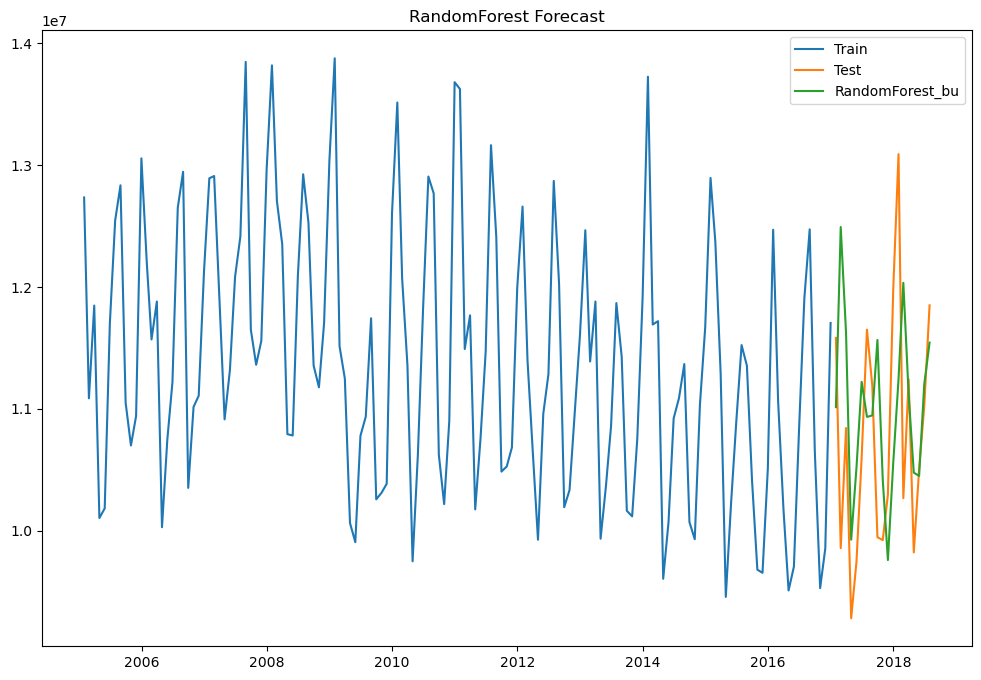

In [7]:
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
plt.plot(month_df.index[-n_test:],preds, label='RandomForest_bu')
plt.legend(loc='best')
plt.title("RandomForest Forecast");

In [8]:
#scores_df=pd.read_csv('scores.csv',index_col=[0])#['rmse']/1_000_000
results.loc['RandomForest_bu']=rmse/1_000_000
results.sort_values('rmse_per_million')#.to_csv('scores.csv')

,rmse_per_million
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
arima,0.737348
RandomForest_bu,0.863608
holt_linear,0.929768
SES,0.942778
moving_average,0.944048
simple_average,1.122177
naive,1.325609


<a id='xgboost'></a>
## II. XGBoost.
[back top](#start)

In [9]:
data=prepping_data(month_df,lag=6)
rmse,test,preds=lets_move_forward(data, n_test,model=xgb.XGBRegressor(random_state=2024))
print('RMSE: ', rmse)

Date 2017-01-31 00:00:00. Expected 11704177.0, predicted 11132719.0
Date 2017-02-28 00:00:00. Expected 11581251.0, predicted 12484507.0
Date 2017-03-31 00:00:00. Expected 9855340.0, predicted 12177974.0
Date 2017-04-30 00:00:00. Expected 10841984.5, predicted 9868039.0
Date 2017-05-31 00:00:00. Expected 9279596.0, predicted 10615849.0
Date 2017-06-30 00:00:00. Expected 9747081.0, predicted 10883004.0
Date 2017-07-31 00:00:00. Expected 10600150.0, predicted 10800999.0
Date 2017-08-31 00:00:00. Expected 11649628.0, predicted 11616893.0
Date 2017-09-30 00:00:00. Expected 11190134.0, predicted 12153026.0
Date 2017-10-31 00:00:00. Expected 9945277.0, predicted 10302984.0
Date 2017-11-30 00:00:00. Expected 9921554.0, predicted 9525508.0
Date 2017-12-31 00:00:00. Expected 10294894.0, predicted 10587588.0
Date 2018-01-31 00:00:00. Expected 11974478.0, predicted 11398379.0
Date 2018-02-28 00:00:00. Expected 13090587.0, predicted 11893795.0
Date 2018-03-31 00:00:00. Expected 10265918.0, predicte

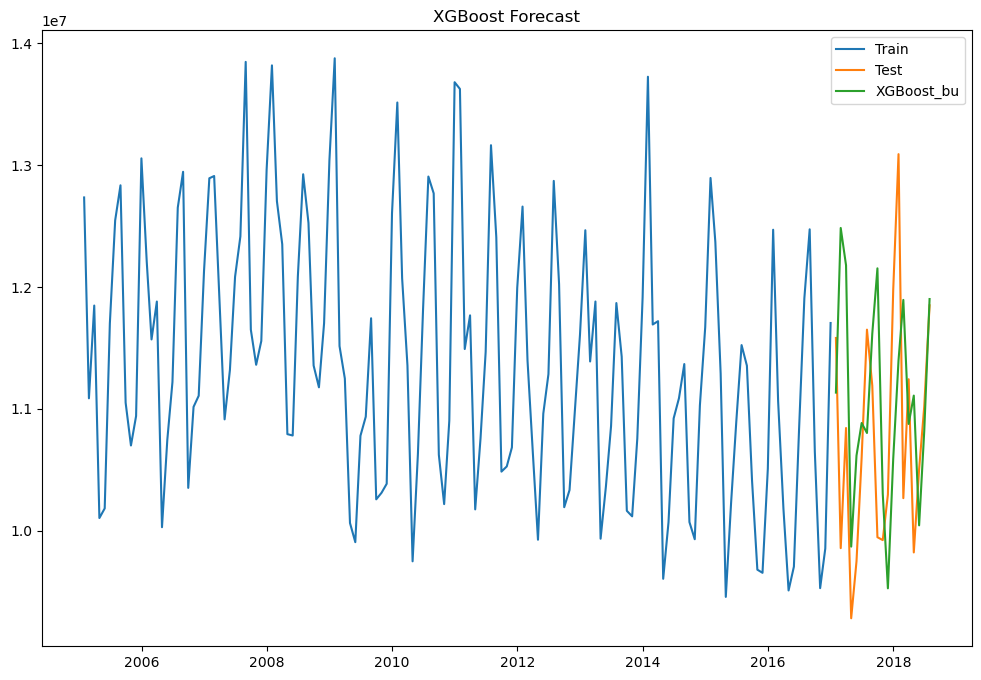

In [10]:
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
plt.plot(month_df.index[-n_test:],preds, label='XGBoost_bu')
plt.legend(loc='best')
plt.title("XGBoost Forecast");

In [11]:
#scores_df=pd.read_csv('scores.csv',index_col=[0])#['rmse']/1_000_000
results.loc['XGBoost_bu']=rmse/1_000_000
results.sort_values('rmse_per_million')#.to_csv('scores.csv')

,rmse_per_million
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
arima,0.737348
RandomForest_bu,0.863608
XGBoost_bu,0.887924
holt_linear,0.929768
SES,0.942778
moving_average,0.944048
simple_average,1.122177


<a id='train_test'></a>
## 2. Train/test split.
[back top](#start)

In [12]:
#creating lags aka look_back

def create_lag_features(data,target,lag_steps=1):
    for i in range(1,lag_steps+1):
        data[f'lag_{i}']=data[target].shift(i)

    return data
    
def create_rolling_mean(data,target,window_size=3):
    data['rolling_mean']=data[target].rolling(window=window_size).mean()
    return data
#fourier transform

def apply_fourier_transform(data,target):
    values=data[target].values
    fourier_transform=fft(values)
    data['fourier_transform']=np.abs(fourier_transform)
    return data
def lets_move_forward_second(data, n_test,model=RandomForestRegressor(n_estimators=100,random_state=2024)):
    
    #Here I will put my predictions
    predictions=[]
    #lets get our terain and test
    train, test=my_own_train_test_split(data,n_test)
    #lets line up the train
    lining_up=[x for x in train]
    for i in range(len(test)):
        testX, testy=test[i,1:],test[i,0]
        pred=lets_doit_modeling(train, testX,model=RandomForestRegressor(n_estimators=100,random_state=2024))
        predictions.append(pred)
        lining_up.append(test[i])
        print(f'Date {dates[-n_test+i]}. Expected {testy}, predicted {pred[0]}')
    err=mean_squared_error(test[:,-1],predictions)
    return np.sqrt(err), test[:,-1], predictions

In [13]:
data=create_lag_features(month_df,'energy',6)
data=create_rolling_mean(data,'energy')
data=apply_fourier_transform(data,'energy')
data=data.dropna()

In [14]:
train,test = my_own_train_test_split(data,19)
X_train=train.drop('energy',axis=1)
y_train=train['energy'].values
X_test=test.drop('energy',axis=1)
y_test=test.energy.values

In [15]:
cv_split=TimeSeriesSplit(n_splits=3)

param_grid = {

    'learning_rate': [0.01, 0.1, 0.2],

    'max_depth': [3, 5, 7],

    'subsample': [0.8, 0.9, 1.0]

}

grid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=cv_split)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

In [16]:
model=xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)
preds_xg=model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,preds_xg))

print('Test Score: %.2f RMSE' % (rmse))


Test Score: 478882.26 RMSE


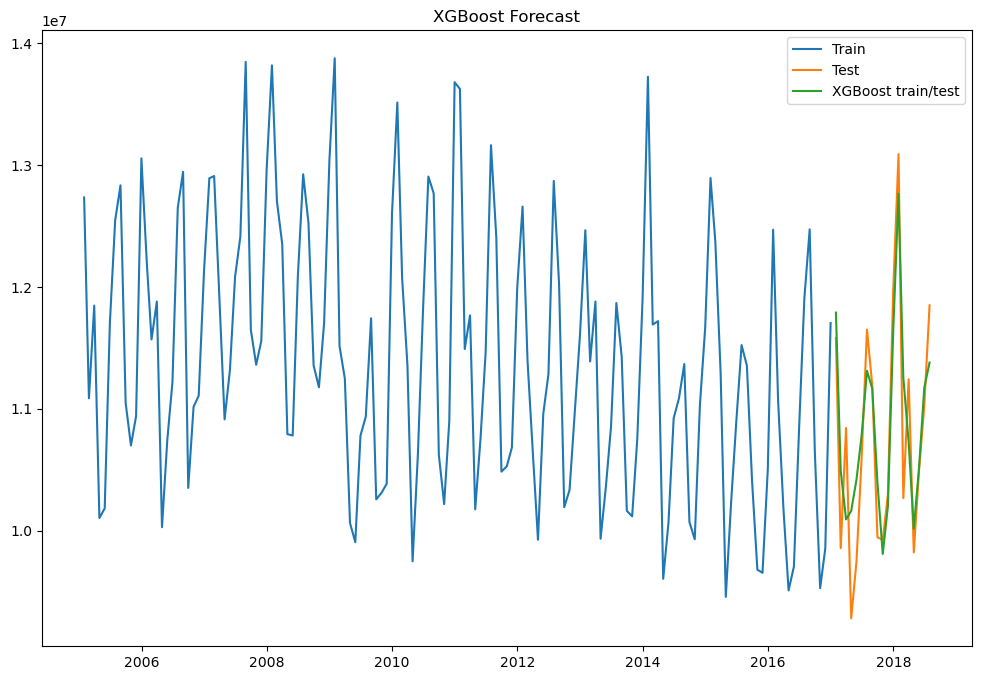

In [17]:
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
plt.plot(month_df.index[-n_test:],preds_xg, label='XGBoost train/test')
plt.legend(loc='best')
plt.title("XGBoost Forecast");

In [18]:

results.loc['XGboost_tt']=rmse/1_000_000
results.sort_values('rmse_per_million')#.to_csv('scores.csv')

,rmse_per_million
XGboost_tt,0.478882
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
arima,0.737348
RandomForest_bu,0.863608
XGBoost_bu,0.887924
holt_linear,0.929768
SES,0.942778
moving_average,0.944048


In [19]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [1, 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
grid_search = RandomizedSearchCV(RandomForestRegressor(), random_grid, cv=cv_split)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_


In [20]:
rf=RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)
preds_rf=rf.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,preds_rf))

print('Test Score: %.2f RMSE' % (rmse))


Test Score: 611216.63 RMSE


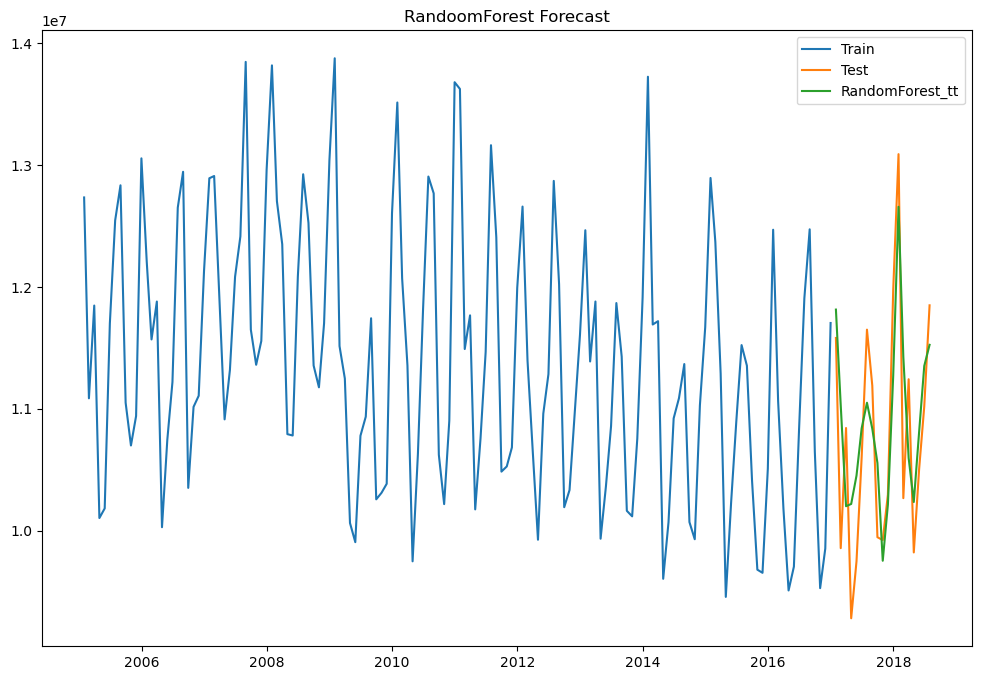

In [22]:
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
plt.plot(month_df.index[-n_test:],preds_rf, label='RandomForest_tt')
plt.legend(loc='best')
plt.title("RandoomForest Forecast");

In [23]:
results.loc['RandomForest_tt']=rmse/1_000_000
results.sort_values('rmse_per_million')#.to_csv('scores.csv')

,rmse_per_million
XGboost_tt,0.478882
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
RandomForest_tt,0.611217
arima,0.737348
RandomForest_bu,0.863608
XGBoost_bu,0.887924
holt_linear,0.929768
SES,0.942778


In [25]:
results.sort_values('rmse_per_million').to_csv('scores.csv')